# ARIM-Academy：　機器データ利活用ユースケース
### 機器：誘導結合プラズマ発光分光分析法（ICP-OES）
### 分析：TPE最適化


## データセット

    
本編で扱う 『茶の元素分析データセット』（data.xlsx）、は、ブラックセイロン(BC)、ブラックトルコ(BT)、グリーンセイロン(GC)、グリーントルコ(GT)の4種類の茶葉について、3つの濃度（1%、2%、3%）で抽出したサンプルの誘導結合プラズマ発光分光分析法（ICP-OES）の元素分析データです。[1]

この研究では、機械学習（回帰分析としてMLR, ANN、および主成分分析、ISOMAP、階層クラスタ分析など）の手法を使い、茶の品種、濃度、浸出時間によるミネラル組成の変化を調査し、特定のミネラルレベルを調整する条件を見つける検討が行われています。

[1] Durmus, Y., Atasoy, A.D. & Atasoy, A.F. Mathematical optimization of multilinear and artificial neural network regressions for mineral composition of different tea types infusions. Sci Rep 14, 18285 (2024). https://doi.org/10.1038/s41598-024-69149-1

---
<br>  
<img src="./img/main_image.jpg" width="50%">
<br> 

---

**Chemical composition** 
* 9種類の元素分析値（Al, Ca, Cu, Fe,K,Mg,Mn,Na,Zn） 

**Experimental parameters**  
* Concentration：　お茶の濃度
* time:　抽出時間

**Label**
* grouped:　品種・色・濃度・抽出時間を識別できる一種の飼料名（MLは使用せず） 
* teaConc:　濃度ラベル（MLは使用せず）
* tea_org:　色ラベル（MLは使用せず）
* tea_var:　品種ラベル（MLは使用せず）
* tea：　　 色と品種ラベル（MLで使用）

### 教材への接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!git clone https://github.com/ARIM-Usecase/Example_2.git
%cd Example_2

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
#汎用ライブラリ
import numpy as np
import pandas as pd
from plotly.io import show

# 回帰分析
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# TPE最適化（Optuna）
import optuna
from optuna.samplers import TPESampler

## 1.データセットの読み込みと前処理


### サンプルファイルの読み込み
pandasライブラリのread_excel()関数は、Excelファイルを読み込んでpandasのDataFrame形式に変換する関数です。ここでは[data]フォルダーにあるdata.xlsxファイルをDataFrameとして読み込み、その結果をdfという変数に格納します。168のサンプルに対して16の特徴量からなるデータ行列となっています。

In [2]:
# データの読み込み
df= pd.read_excel('./data/data.xlsx', header = 1)
df

Al     Ca        Cu     Fe       K      Mg      Mn     Na     Zn  \
0     3.297  4.356  0.031290  0.067   99.06   3.531   1.455  0.541  0.131   
1     4.267  4.118  0.031290  0.079  106.50   3.378   1.542  0.603  0.126   
2     4.088  4.763  0.033370  0.084  114.00   4.763   1.838  1.058  0.156   
3     4.338  4.556  0.033370  0.091  122.60   5.005   2.269  0.958  0.162   
4     4.732  5.138  0.035514  0.110  132.40   5.626   2.998  1.510  0.165   
..      ...    ...       ...    ...     ...     ...     ...    ...    ...   
163  16.690  8.895  0.153000  0.236  323.40  20.450  10.420  6.360  0.335   
164  17.620  8.909  0.177000  0.261  334.20  23.486  11.330  7.133  0.351   
165  17.920  9.056  0.180000  0.266  332.30  22.840  11.290  7.609  0.358   
166  17.820  9.128  0.175000  0.273  367.30  24.560  12.110  8.537  0.372   
167  17.650  9.048  0.197000  0.285  358.40  24.340  12.310  8.631  0.378   

                grouped tea  Concentration  time teaConc tea_org tea_var  
0     Black Turkish 1 2  BT              1     2     BT1   black   turki  
1     Black Turkish 1 2  BT              1     2     BT1   black   turki  
2     Black Turkish 1 5  BT              1     5     BT1   black   turki  
3     Black Turkish 1 5  BT              1     5     BT1   black   turki  
4    Black Turkish 1 10  BT              1    10     BT1   black   turki  
..                  ...  ..            ...   ...     ...     ...     ...  
163   Green Ceylan 3 30  GC              3    30     GC3   green  ceylon  
164   Green Ceylan 3 45  GC              3    45     GC3   green  ceylon  
165   Green Ceylan 3 45  GC              3    45     GC3   green  ceylon  
166   Green Ceylan 3 60  GC              3    60     GC3   green  ceylon  
167   Green Ceylan 3 60  GC              3    60     GC3   green  ceylon  

[168 rows x 16 columns]

In [3]:
# 特徴量とターゲットの分離
X = df[['Concentration', 'time']]
y_Fe = df['Fe']
y_Al = df['Al']
y_Mn = df['Mn']

### Optuna目的関数の定義

In [6]:
# 目的関数の定義 (MLR 用)
def objective_mlr(trial):
    # MLR モデルの定義
    model = LinearRegression()

    # 試行による最適化パラメータ
    X_train = pd.DataFrame({
        'Concentration': [trial.suggest_float('Concentration', 1.0, 3.0)],
        'time': [trial.suggest_float('time', 2.0, 60.0)]
    })
    
    # モデルのトレーニング
    model.fit(X, y_Fe)

    # 予測
    y_pred_Fe = model.predict(X_train)
    y_pred_Al = model.predict(X_train)
    y_pred_Mn = model.predict(X_train)

    # 目的関数の計算（Fe の最大化、Al の最小化、Mn の安定化）
    return -((y_pred_Fe[0] - y_pred_Al[0]) - abs(y_pred_Mn[0] - 5.3))

### Optuna最適化実行

In [7]:
# Optunaによる最適化 (MLR)
study_mlr = optuna.create_study(direction='minimize', 
                                sampler=TPESampler()
                                )

study_mlr.optimize(objective_mlr, n_trials=500)

# 最適解の表示
print(f"MLR 最適解: {study_mlr.best_params}")

[I 2024-09-21 18:21:44,385] A new study created in memory with name: no-name-8da53ac8-ec95-489d-96e0-969f0a269c5c


[I 2024-09-21 18:21:44,419] Trial 0 finished with value: 5.204780118793714 and parameters: {'Concentration': 1.504529968021435, 'time': 6.727511964979433}. Best is trial 0 with value: 5.204780118793714.
[I 2024-09-21 18:21:44,419] Trial 1 finished with value: 5.161436907722663 and parameters: {'Concentration': 2.3556093838988668, 'time': 15.105240089972831}. Best is trial 1 with value: 5.161436907722663.
[I 2024-09-21 18:21:44,430] Trial 2 finished with value: 5.131417234127753 and parameters: {'Concentration': 2.057751109324807, 'time': 41.80927585318426}. Best is trial 2 with value: 5.131417234127753.
[I 2024-09-21 18:21:44,436] Trial 3 finished with value: 5.1540367836689915 and parameters: {'Concentration': 2.9369232788590605, 'time': 6.2650785855633995}. Best is trial 2 with value: 5.131417234127753.
[I 2024-09-21 18:21:44,436] Trial 4 finished with value: 5.17404196397476 and parameters: {'Concentration': 2.181380349763855, 'time': 10.942620216686525}. Best is trial 2 with value:

MLR 最適解: {'Concentration': 2.9996744660561867, 'time': 59.98684535793783}


### 可視化プロット

In [8]:
# 結果のプロット (オプション)
fig = optuna.visualization.plot_optimization_history(study_mlr)

fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定

show(fig)

In [9]:
# 結果のプロット (オプション)
fig = optuna.visualization.plot_contour(study_mlr)

fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定
show(fig)


In [10]:
# 目的関数の定義 (ANN 用)
def objective_ann(trial):
    # ANN モデルの定義
    model = Sequential()
    model.add(Input(shape=(2,)))  # input_dim の代わりに Input レイヤーを使用
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # 最適化アルゴリズムと損失関数
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # 試行による最適化パラメータ
    X_train = np.array([[trial.suggest_float('Concentration', 1.0, 3.0),
                         trial.suggest_float('time', 2.0, 60.0)]])
    
    # モデルのトレーニング
    model.fit(X, y_Fe, epochs=10, verbose=0)

    # 予測
    y_pred_Fe = model.predict(X_train)
    y_pred_Al = model.predict(X_train)
    y_pred_Mn = model.predict(X_train)

    # 目的関数の計算（Fe の最大化、Al の最小化、Mn の安定化）
    return -((y_pred_Fe[0][0] - y_pred_Al[0][0]) - abs(y_pred_Mn[0][0] - 5.3))


In [11]:
# Optunaによる最適化 (ANN)
study_ann = optuna.create_study(direction='minimize', 
                                sampler=TPESampler()
                                )

study_ann.optimize(objective_ann, n_trials=100)
print(f"ANN 最適解: {study_ann.best_params}")

[I 2024-09-21 18:22:55,440] A new study created in memory with name: no-name-29fd7eb7-1b07-49b4-9e7b-69c6e764737c


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:22:57,001] Trial 0 finished with value: 5.373582738637924 and parameters: {'Concentration': 2.5207510993212603, 'time': 4.292049996462685}. Best is trial 0 with value: 5.373582738637924.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2024-09-21 18:22:58,268] Trial 1 finished with value: 5.243472448736429 and parameters: {'Concentration': 2.6879295213714025, 'time': 8.98476704685269}. Best is trial 1 with value: 5.243472448736429.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2024-09-21 18:22:59,681] Trial 2 finished with value: 4.796337592601776 and parameters: {'Concentration': 2.438517872453773, 'time': 22.680079987545884}. Best is trial 2 with value: 4.796337592601776.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:23:01,045] Trial 3 finished with value: 4.695159304141998 and parameters: {'Concentration': 1.3940506908138006, 'time': 41.796742512283764}. Best is trial 3 with value: 4.695159304141998.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:23:02,294] Trial 4 finished with value: 5.338819544017315 and parameters: {'Concentration': 2.2458859215729308, 'time': 58.775111191049675}. Best is trial 3 with value: 4.695159304141998.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2024-09-21 18:23:03,559] Trial 5 finished with value: 6.231036591529846 and parameters: {'Concentration': 2.7215069640632623, 'time': 39.96525119535516}. Best is trial 3 with value: 4.695159304141998.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:04,834] Trial 6 finished with value: 5.370106863975525 and parameters: {'Concentration': 1.871891275185748, 'time': 54.6950802127318}. Best is trial 3 with value: 4.695159304141998.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2024-09-21 18:23:06,209] Trial 7 finished with value: 7.1246394395828245 and parameters: {'Concentration': 1.0717444827169647, 'time': 59.14944465980475}. Best is trial 3 with value: 4.695159304141998.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:23:07,544] Trial 8 finished with value: 5.034508365392685 and parameters: {'Concentration': 2.722215416289945, 'time': 11.579156851058448}. Best is trial 3 with value: 4.695159304141998.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2024-09-21 18:23:08,822] Trial 9 finished with value: 2.3478720664978026 and parameters: {'Concentration': 1.2854682858945585, 'time': 40.163425923161675}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-09-21 18:23:10,155] Trial 10 finished with value: 5.44049981534481 and parameters: {'Concentration': 1.6808205341658478, 'time': 29.54333877880967}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2024-09-21 18:23:11,682] Trial 11 finished with value: 5.359257637709379 and parameters: {'Concentration': 1.2521896300129534, 'time': 43.30077076199156}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2024-09-21 18:23:13,000] Trial 12 finished with value: 5.116145122051239 and parameters: {'Concentration': 1.4534974709467743, 'time': 42.421188323078724}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2024-09-21 18:23:14,359] Trial 13 finished with value: 4.7080925583839415 and parameters: {'Concentration': 1.4682912671009152, 'time': 34.68421708743508}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:23:15,730] Trial 14 finished with value: 5.423595379292965 and parameters: {'Concentration': 1.0443225906661766, 'time': 49.52667514506068}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-09-21 18:23:17,130] Trial 15 finished with value: 5.275074434652924 and parameters: {'Concentration': 1.9314378017395049, 'time': 27.993406366891847}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:18,449] Trial 16 finished with value: 4.942094612121582 and parameters: {'Concentration': 1.5255889349357679, 'time': 48.97187292876271}. Best is trial 9 with value: 2.3478720664978026.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:19,752] Trial 17 finished with value: 1.9584966182708738 and parameters: {'Concentration': 1.2855864658062794, 'time': 21.431386236582505}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:21,081] Trial 18 finished with value: 4.987168598175049 and parameters: {'Concentration': 2.9769963100842336, 'time': 18.829682427108978}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2024-09-21 18:23:22,383] Trial 19 finished with value: 5.2920758847147225 and parameters: {'Concentration': 1.6755414863957394, 'time': 19.18828111595674}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:23,695] Trial 20 finished with value: 5.222993682324886 and parameters: {'Concentration': 1.2569484879029602, 'time': 35.20770053164939}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:25,290] Trial 21 finished with value: 6.068385887145996 and parameters: {'Concentration': 1.2420919496779543, 'time': 36.890837254965476}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2024-09-21 18:23:26,625] Trial 22 finished with value: 5.226827013492584 and parameters: {'Concentration': 1.3781635325991488, 'time': 26.349172601890707}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2024-09-21 18:23:28,049] Trial 23 finished with value: 5.049667257070541 and parameters: {'Concentration': 1.719640068661104, 'time': 47.20173139662401}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2024-09-21 18:23:29,448] Trial 24 finished with value: 5.12257716357708 and parameters: {'Concentration': 2.119626636467001, 'time': 31.536518284787267}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-09-21 18:23:30,880] Trial 25 finished with value: 5.172937351465225 and parameters: {'Concentration': 1.1578475195891975, 'time': 16.334387779142062}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:23:32,296] Trial 26 finished with value: 5.305290313623845 and parameters: {'Concentration': 1.5779148763090873, 'time': 39.109421239223835}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2024-09-21 18:23:33,644] Trial 27 finished with value: 5.217346835136413 and parameters: {'Concentration': 1.3428905811302245, 'time': 23.962296939781382}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:35,177] Trial 28 finished with value: 5.876937198638916 and parameters: {'Concentration': 1.0006236446284489, 'time': 45.400518263676965}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2024-09-21 18:23:36,705] Trial 29 finished with value: 5.181115086376667 and parameters: {'Concentration': 1.8441567149125988, 'time': 32.9414784063899}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2024-09-21 18:23:38,237] Trial 30 finished with value: 5.040806758403778 and parameters: {'Concentration': 1.1889556488578166, 'time': 2.6167196276391493}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2024-09-21 18:23:39,812] Trial 31 finished with value: 5.05453282892704 and parameters: {'Concentration': 1.4233954294754498, 'time': 37.51722881233866}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2024-09-21 18:23:41,280] Trial 32 finished with value: 5.188143979012966 and parameters: {'Concentration': 1.348954463306619, 'time': 34.35380236813937}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-09-21 18:23:43,151] Trial 33 finished with value: 5.049442428350448 and parameters: {'Concentration': 1.5469186506926629, 'time': 12.010119036992435}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2024-09-21 18:23:44,663] Trial 34 finished with value: 5.2413382336497305 and parameters: {'Concentration': 1.782277726434722, 'time': 41.047105482248995}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:23:46,178] Trial 35 finished with value: 5.4375028789043425 and parameters: {'Concentration': 2.090763303941737, 'time': 52.34432244357369}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2024-09-21 18:23:48,086] Trial 36 finished with value: 5.147676426172256 and parameters: {'Concentration': 1.1286251737628166, 'time': 23.734583014426143}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2024-09-21 18:23:51,993] Trial 37 finished with value: 4.956322032213211 and parameters: {'Concentration': 2.3110698484356216, 'time': 32.31494453376121}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-09-21 18:23:55,842] Trial 38 finished with value: 5.615048903226852 and parameters: {'Concentration': 1.519689599364648, 'time': 6.402751860738576}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2024-09-21 18:23:59,639] Trial 39 finished with value: 5.074826049804687 and parameters: {'Concentration': 1.6052515605166873, 'time': 43.82273343843453}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2024-09-21 18:24:03,434] Trial 40 finished with value: 5.377692925930023 and parameters: {'Concentration': 1.3232124719051144, 'time': 27.055627264773328}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2024-09-21 18:24:07,023] Trial 41 finished with value: 4.703197705745697 and parameters: {'Concentration': 2.5582119598881246, 'time': 22.292205841322662}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2024-09-21 18:24:10,842] Trial 42 finished with value: 5.613352912664413 and parameters: {'Concentration': 2.584110597003048, 'time': 20.754862566701426}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2024-09-21 18:24:14,519] Trial 43 finished with value: 5.062210801243782 and parameters: {'Concentration': 2.8979440108028625, 'time': 15.39832249998957}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2024-09-21 18:24:18,217] Trial 44 finished with value: 4.532225954532623 and parameters: {'Concentration': 2.4381862458948755, 'time': 28.93607915758702}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2024-09-21 18:24:21,881] Trial 45 finished with value: 5.045875298976898 and parameters: {'Concentration': 2.455748206560881, 'time': 25.184064137804764}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2024-09-21 18:24:25,656] Trial 46 finished with value: 5.137362468242645 and parameters: {'Concentration': 2.7948437507779533, 'time': 29.888214125707062}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-09-21 18:24:30,271] Trial 47 finished with value: 5.302223508432507 and parameters: {'Concentration': 2.3252307934969907, 'time': 21.309941561312968}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2024-09-21 18:24:33,933] Trial 48 finished with value: 5.540007907152176 and parameters: {'Concentration': 2.588103695240732, 'time': 15.887661477469912}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2024-09-21 18:24:37,579] Trial 49 finished with value: 9.916919898986816 and parameters: {'Concentration': 2.196957139051036, 'time': 55.899140500845505}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[I 2024-09-21 18:24:41,291] Trial 50 finished with value: 5.644635397195816 and parameters: {'Concentration': 2.495839789774565, 'time': 28.511177042158025}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2024-09-21 18:24:44,985] Trial 51 finished with value: 5.104713547229767 and parameters: {'Concentration': 1.4589245831441828, 'time': 36.51942276654851}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2024-09-21 18:24:48,709] Trial 52 finished with value: 5.59816934466362 and parameters: {'Concentration': 2.67100241458037, 'time': 38.295864588449874}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2024-09-21 18:24:52,455] Trial 53 finished with value: 5.129447582364082 and parameters: {'Concentration': 2.3595786652885966, 'time': 40.147347580793735}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2024-09-21 18:24:56,232] Trial 54 finished with value: 5.4598354429006575 and parameters: {'Concentration': 2.0082581551058953, 'time': 30.300364290353887}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2024-09-21 18:24:59,917] Trial 55 finished with value: 2.9975822448730467 and parameters: {'Concentration': 1.2759793529745627, 'time': 34.7511869190689}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-09-21 18:25:03,607] Trial 56 finished with value: 5.56119190454483 and parameters: {'Concentration': 1.083305223848884, 'time': 18.321958882205447}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2024-09-21 18:25:07,223] Trial 57 finished with value: 5.301905046403408 and parameters: {'Concentration': 1.2544475186803004, 'time': 42.0414278292674}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2024-09-21 18:25:10,761] Trial 58 finished with value: 4.866156446933746 and parameters: {'Concentration': 2.8009629453180427, 'time': 45.32820344569228}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2024-09-21 18:25:14,762] Trial 59 finished with value: 5.369864712655544 and parameters: {'Concentration': 1.2056613578244946, 'time': 12.740154754029714}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:17,110] Trial 60 finished with value: 6.667156982421875 and parameters: {'Concentration': 1.3086900050735057, 'time': 34.0983903011862}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:18,203] Trial 61 finished with value: 5.093104916810989 and parameters: {'Concentration': 1.4213853500991374, 'time': 35.417398867313764}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-09-21 18:25:19,402] Trial 62 finished with value: 4.957832473516464 and parameters: {'Concentration': 1.104272914368141, 'time': 26.12788822405555}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:21,139] Trial 63 finished with value: 5.137941214442253 and parameters: {'Concentration': 1.499008154179845, 'time': 32.73391205270078}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2024-09-21 18:25:22,315] Trial 64 finished with value: 5.568543004989624 and parameters: {'Concentration': 1.6131498219278702, 'time': 21.871133690452197}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2024-09-21 18:25:23,539] Trial 65 finished with value: 5.11187304854393 and parameters: {'Concentration': 1.366433697940391, 'time': 48.839190748628056}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:24,884] Trial 66 finished with value: 5.023561316728592 and parameters: {'Concentration': 1.2783263424903604, 'time': 39.665949509979455}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:26,159] Trial 67 finished with value: 10.446970748901368 and parameters: {'Concentration': 1.1559093029696537, 'time': 29.184181968381818}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2024-09-21 18:25:27,483] Trial 68 finished with value: 5.218212734162807 and parameters: {'Concentration': 1.4046871350789893, 'time': 31.21314063729303}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2024-09-21 18:25:28,744] Trial 69 finished with value: 5.216771993041038 and parameters: {'Concentration': 1.6663296955045355, 'time': 37.07857276151559}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2024-09-21 18:25:30,022] Trial 70 finished with value: 7.963859128952026 and parameters: {'Concentration': 1.021885614701693, 'time': 43.26651016434461}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:31,303] Trial 71 finished with value: 5.180898132920265 and parameters: {'Concentration': 2.60458148134258, 'time': 22.611175070143965}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2024-09-21 18:25:32,602] Trial 72 finished with value: 5.1630141466856 and parameters: {'Concentration': 2.4164349106070016, 'time': 24.443865937453168}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2024-09-21 18:25:33,833] Trial 73 finished with value: 4.98439319729805 and parameters: {'Concentration': 2.5291852183439625, 'time': 27.8014782865053}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2024-09-21 18:25:35,098] Trial 74 finished with value: 5.4193360090255736 and parameters: {'Concentration': 2.2338384049349793, 'time': 20.04461101793992}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-09-21 18:25:36,372] Trial 75 finished with value: 5.158009099960327 and parameters: {'Concentration': 1.2078917124132653, 'time': 18.34504414220085}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2024-09-21 18:25:37,663] Trial 76 finished with value: 5.388454931974411 and parameters: {'Concentration': 1.9143375761959702, 'time': 14.010842753085683}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:38,927] Trial 77 finished with value: 5.693688976764679 and parameters: {'Concentration': 2.666408218592913, 'time': 23.17465636183497}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:40,232] Trial 78 finished with value: 5.088363888859749 and parameters: {'Concentration': 2.3973744962356562, 'time': 34.01699162548434}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2024-09-21 18:25:41,516] Trial 79 finished with value: 5.078793171048164 and parameters: {'Concentration': 1.4718226907885132, 'time': 26.0692482324059}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:42,830] Trial 80 finished with value: 4.888690757751465 and parameters: {'Concentration': 1.7380397954007898, 'time': 9.801396789896721}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:44,078] Trial 81 finished with value: 5.300272799283266 and parameters: {'Concentration': 2.81232923500996, 'time': 45.40899717873465}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2024-09-21 18:25:46,007] Trial 82 finished with value: 4.430983173847198 and parameters: {'Concentration': 2.709144655045915, 'time': 47.73406946353956}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:47,305] Trial 83 finished with value: 5.535145837068558 and parameters: {'Concentration': 2.7563612355991256, 'time': 51.075639962794114}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2024-09-21 18:25:48,698] Trial 84 finished with value: 5.083733397722244 and parameters: {'Concentration': 2.909474915591128, 'time': 47.2889414035987}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2024-09-21 18:25:50,018] Trial 85 finished with value: 5.572801995277405 and parameters: {'Concentration': 2.5189679688296644, 'time': 41.8445409251986}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2024-09-21 18:25:51,316] Trial 86 finished with value: 5.247493076324463 and parameters: {'Concentration': 2.6372993624006207, 'time': 17.300456894202277}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2024-09-21 18:25:52,598] Trial 87 finished with value: 5.390334720909595 and parameters: {'Concentration': 2.7202379739403515, 'time': 35.3424333071014}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2024-09-21 18:25:53,891] Trial 88 finished with value: 5.250910627841949 and parameters: {'Concentration': 1.3016636982134113, 'time': 38.70797655333684}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:55,229] Trial 89 finished with value: 4.929725724458694 and parameters: {'Concentration': 2.554192168586067, 'time': 40.89984973889794}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[I 2024-09-21 18:25:56,538] Trial 90 finished with value: 5.053889709711075 and parameters: {'Concentration': 2.471342570444256, 'time': 44.498268786789154}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2024-09-21 18:25:57,903] Trial 91 finished with value: 4.633990514278412 and parameters: {'Concentration': 2.824799470992845, 'time': 45.46165755257242}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:25:59,194] Trial 92 finished with value: 11.573653507232667 and parameters: {'Concentration': 2.8327918406613395, 'time': 47.0923122514389}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2024-09-21 18:26:00,536] Trial 93 finished with value: 4.908107656240463 and parameters: {'Concentration': 2.9686303258878697, 'time': 53.28570473933415}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2024-09-21 18:26:01,870] Trial 94 finished with value: 5.101799595355987 and parameters: {'Concentration': 2.731458541979669, 'time': 49.79796581558227}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-09-21 18:26:03,254] Trial 95 finished with value: 5.140486451983452 and parameters: {'Concentration': 2.1415376255443452, 'time': 42.585672186380364}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2024-09-21 18:26:04,616] Trial 96 finished with value: 5.588921386003494 and parameters: {'Concentration': 2.6327255980574544, 'time': 46.71705206791988}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2024-09-21 18:26:05,915] Trial 97 finished with value: 4.985945481061935 and parameters: {'Concentration': 2.881306027684586, 'time': 24.783078546818306}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2024-09-21 18:26:07,224] Trial 98 finished with value: 5.180277156829834 and parameters: {'Concentration': 1.3862309502224812, 'time': 37.85824404804296}. Best is trial 17 with value: 1.9584966182708738.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2024-09-21 18:26:08,524] Trial 99 finished with value: 5.086753073334694 and parameters: {'Concentration': 1.2232979404265354, 'time': 36.167157243305496}. Best is trial 17 with value: 1.9584966182708738.


ANN 最適解: {'Concentration': 1.2855864658062794, 'time': 21.431386236582505}


### 可視化プロット

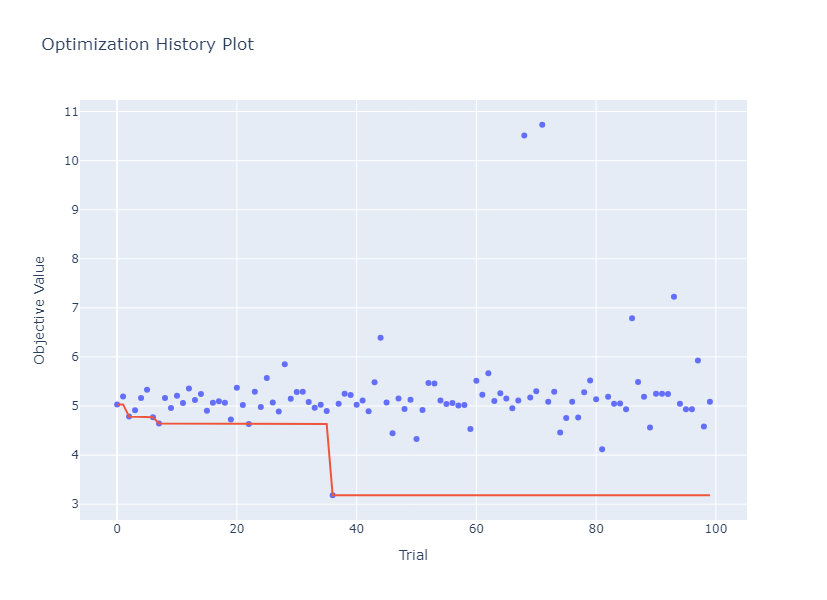

In [12]:
# 結果のプロット (オプション)
fig = optuna.visualization.plot_optimization_history(study_ann)

fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定
show(fig)


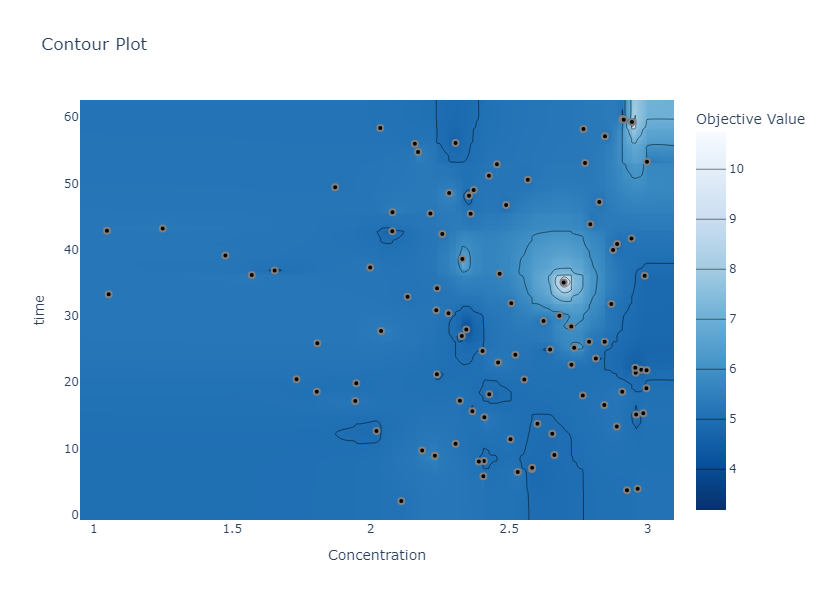

In [13]:
# 結果のプロット (オプション)
fig = optuna.visualization.plot_contour(study_ann)
fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定
show(fig)


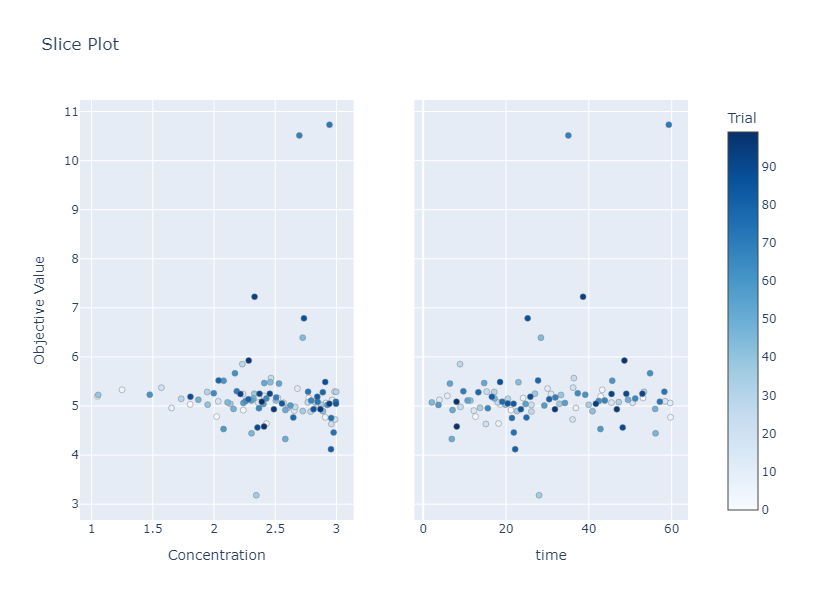

In [14]:
# 結果のプロット (スライスプロット)
fig = optuna.visualization.plot_slice(study_ann)
fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定
show(fig)
